# Using IPython Notebooks

IPython notebooks are made up of a number of 'cells'. Each cell can either run some python code or contain text.

To run a cell, click on it or move to it with up and down arrows and press 'Shift + Enter'. Alternatively, you can press the 'play' button in the toolbar. Any output from the cell (text or plots) will apprear below the cell after you run it Try running the cell below!

In [2]:
print "Hello World!"

Hello World!


Before you can do much in Python, you'll probably need to import one or a few libraries. NumPy is a matrix library that is used in scientific python applications. The 'import X as Y' statement loads a library X under the alias Y.

In [3]:
import numpy as np

IPython can tell you about the properties of functions and modules/libraries. One way to get this is to 'tab complete'. Given a library, 'np', you can query the function in the library by typing 'np.' and pressing 'Tab'. Give it a try! You need have imported numpy for this information to be available, so before trying this make sure you've executed the previous cell.

In [4]:
np.

SyntaxError: invalid syntax (<ipython-input-4-a58a88215da2>, line 1)

To learn about a function, you can type the functions name then a question mark and run the cell.

In [5]:
np.zeros?

# Positive Only Sparse Coding on MNIST

This code implements Positive Only Sparse Coding on MNIST.

Lets break that down.

Sparse Coding is an algorithm that seeks to disentangle the underlying generative factors of data. In this particular case, we are considering the dataset, MNIST, which is a collection of digits. Intuitively speaking, the underlying generative factors of digits are pen strokes. When these strokes are combined in the right way, we get digits. We will see that sparse coding discovers this underlying structure. 

In sparse coding, we define the following:
$I$ is an image, $D$ is a dictionary of underlying generative factors, and $A$ the sparse coefficients. We seek to write our image as a weighted sum of the dictionary elements. In equation form, 

$$I(x) = d_1(x) * a_1 + d_2(x) * a_2 + \ldots$$

where the dictionary elements are the same for any image in the data set, and the coefficients, $a$, are different for each image. 

In order to learn the dictionary elements $D$, and the sparse coefficients, $A$, we minimize the following objective function:

$$E = |I - A * D| ^ 2 + |A|_1 \qquad \sum_x d_i(x)^2 = 1$$

(Note $D$ is number of dictionary elements by the number of pixels). To minimize this function, we do the following steps:

0. Choose an initial value of $D$.

1. Choose a batch of images $I$.

2. Minimize $E$ with respect to $A$ - we use FISTA which is a slighly better version of gradient descent.

3. Keeping that value of $A$, change $D$ one gradient step to reduce the value of $E$.

4. Return to step 1. 

### Import libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8,8)
from scipy.io import savemat, loadmat
from scipy.stats import probplot, expon

from utils.rf_plot import show_fields

from network import Network

### Load Data

In [2]:
data_dir = "data/"
data_file = "mnist.mat"
output_dir = 'output/'

data = loadmat(data_dir + data_file)
IMAGES = data['IMAGES']
LABELS = data['LABELS']

# Set basic parameters
(K, L_img, L_img) = IMAGES.shape
print('Number of images: '+str(K))
K # Number of base images
L_img # Linear size of images from the data
N_pix_img = L_img ** 2

# Scale the images to have a constant standard deviation
IMAGES = IMAGES / np.std(IMAGES.astype(float), axis = (1, 2), keepdims = True)
data = IMAGES.reshape(-1, N_pix_img)
order = np.random.permutation(data.shape[0]) # Permute the data since they are sorted by digit
data = data[order]

pos_only = True # Positive Only Sparse coding if True
N_sp = 81 # Number of sparse dictionary elements
lamb = 0.5 # Sparsity parameter (0.5 is a good value, too large and you'll get NaNs)
eta = 0.05 # Dictionary Learning Step Size

Number of images: 60000


### Create Sparse Coding Network

In [3]:
net = Network(N_sp, N_pix_img, lamb, eta)

Inspect the functions in the network.

In [9]:
net.

SyntaxError: invalid syntax (<ipython-input-9-ced4a4750f30>, line 1)

Visualize the untrained dictionary

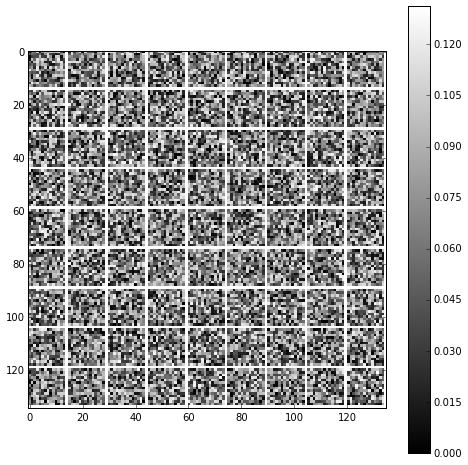

In [5]:
show_fields(net.D, pos_only = True)

Run inference on the network

119.79328112
98.0786001824
96.6373082319
96.1079755276
95.9185034469
95.863720772
95.8556100241
95.8571100651
95.8568881564
95.8549177696


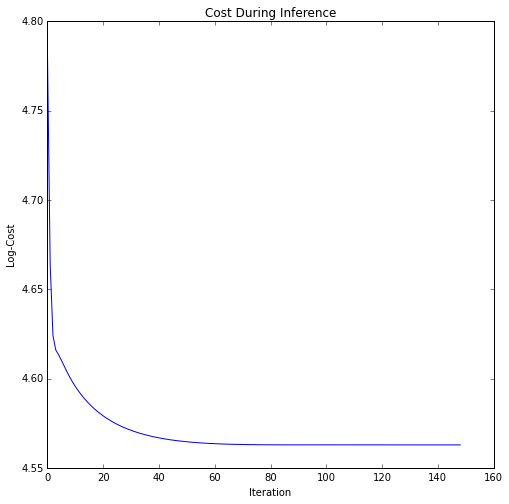

In [6]:
A, costs = net.infer_A(data[0:100], n_g_steps=150, track_cost=True)
plt.plot(np.log(costs))
plt.title('Cost During Inference')
plt.xlabel('Iteration')
plt.ylabel('Log-Cost')

Train the network and visualize the dictionary elements. Run the cell multiple times to train it more (or change the n_epochs parameter). Then plot the dictionary elements again

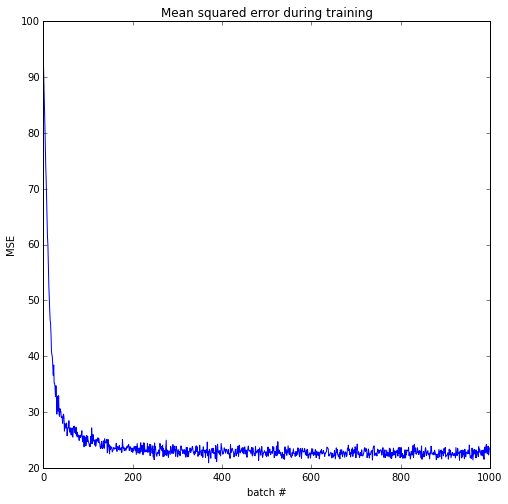

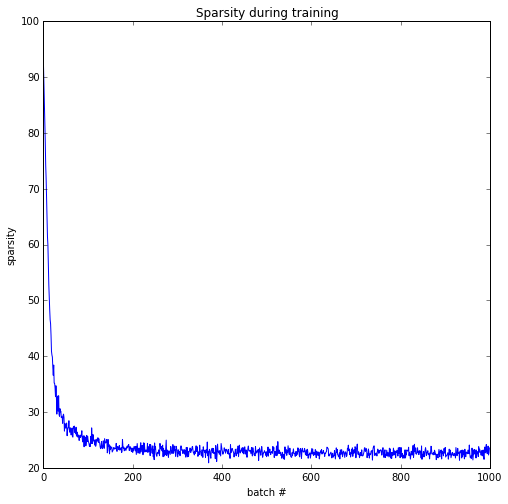

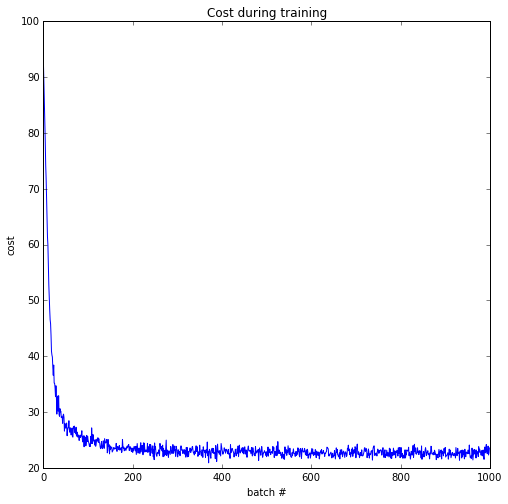

In [4]:
[MSE_hist, sparsity_hist, SNR_hist, cost_hist] = net.train(data, reset=False, batch_size=100, n_batches=1000, eta = eta)

plt.plot(MSE_hist)
plt.title('Mean squared error during training')
plt.xlabel('batch #')
plt.ylabel('MSE')

plt.figure()

plt.plot(sparsity_hist)
plt.title('Sparsity during training')
plt.xlabel('batch #')
plt.ylabel('sparsity')

plt.figure()

plt.plot(cost_hist)
plt.title('Cost during training')
plt.xlabel('batch #')
plt.ylabel('cost')


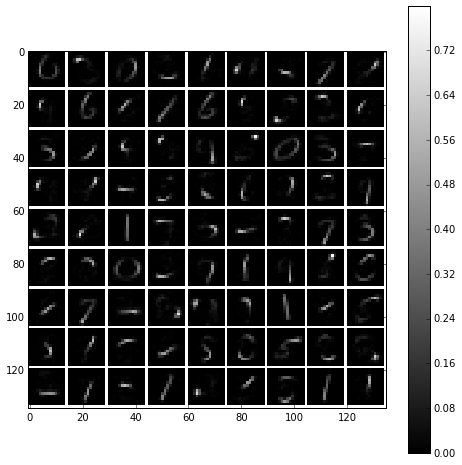

In [5]:
show_fields(net.D, cmap='gray', pos_only=True)

Visualize the reconstructions in more detail for a particular image

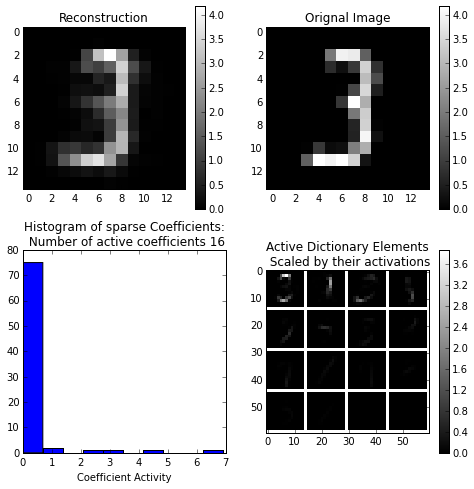

In [44]:
q = np.random.randint(net.A.shape[0])
plt.subplot(2, 2, 1)
plt.title('Reconstruction')
plt.imshow(net.reconstruct(net.X, net.A)[q].reshape(L_img, L_img),
           interpolation = 'nearest',
           cmap = plt.cm.gray, vmin = 0, vmax = net.X[q].reshape(L_img, L_img).max())
plt.colorbar()
plt.subplot(2, 2, 2)
plt.title('Orignal Image')
plt.imshow(net.X[q].reshape(L_img, L_img),
           interpolation = 'nearest',
           cmap = plt.cm.gray)
plt.colorbar()
plt.subplot(2, 2, 3)

plt.hist(net.A[q])

sort_idx = np.argsort(net.A[q])[::-1]
N_active = np.sum(net.A[q] > 0.0)
active_idx = sort_idx[0:N_active]

plt.title('Histogram of sparse Coefficients: \n Number of active coefficients %d' % N_active)
plt.xlabel('Coefficient Activity')

plt.subplot(2, 2, 4)
show_fields(net.D[active_idx] * 
            net.A[q][active_idx][:, np.newaxis], 
            cmap = plt.cm.gray, pos_only = True)
plt.title('Active Dictionary Elements \n Scaled by their activations')

Look at the joint statistics between different sparse coefficients

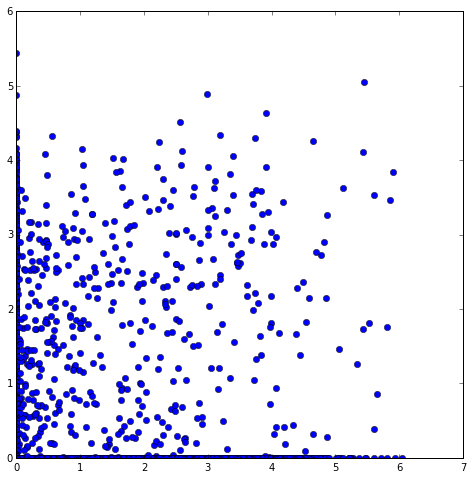

In [46]:
A = net.infer_A(data[:10000])
n1, n2 = np.random.permutation(net.A.shape[1])[:2]
plt.plot(A[:,n1], A[:,n2], 'bo')


Check that the distribution of non-zero coefficients is exponentially distributed using a probability plot. 

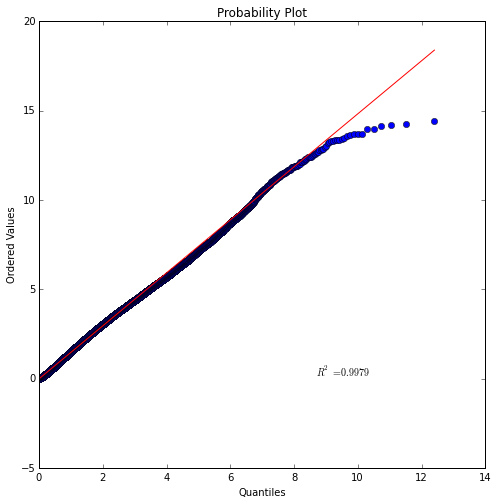

In [47]:
As = net.A.ravel()
p = probplot(As[As > 0], dist = expon, plot = plt)

Details on FISTA:

Since the objective function has an absolute value, typical gradient descent approaches converge slowly. Thus there are special purpose gradient descent methods that minimize functions that are in the form $$f(x) + g(x)$$ where $f(x)$ is a continuously differentiable, convex function and $g(x)$ is a convex, but not continuously differentiable function, such as $g(x) = \alpha |x|$. One such method is called FISTA, or the Fast Iterative Shrinkage-Threshold Algorithm. 

The core kernel of the FISTA algorithm is the ISTA step:

Define
$$p_L(y) = \text{argmin}_x \, g(x) + L/2 * ||x- g(y)||^2$$ where $$g(y) = y - \frac{1}{L} \nabla f(y)$$

and where $L$ is the constant such that $$||\nabla f(x) - \nabla f(y)|| \le L ||x - y||$$

When $g(x) = \alpha|x|_1$, then $$p_L(y) = h_\theta(g(y))\qquad h_\theta(y) = \text{sign}(y)(|y|-\theta)\qquad \theta = \frac{\alpha}{L}$$
$h$ is applied pointwise its input and is called the shrinkage function. Simplying calculating $x_{t+1} = p_L(x_t)$ is the ISTA algorithm. If we more intelligently choose our new value to probe our function, then we get faster convergence. The FISTA algorithm is as follows:

1. Initialize $y_0 = x_0 = X0$, $t_0=1$. 

2. For $k \ge 0$, iterate the following:

$$x_{k+1} = p_L(y_k)\qquad t_{k+1} = 0.5 * (1 + \sqrt{1 + 4 * t_k ^2})\qquad y_{k+1} = x_{k+1} + \frac{t_k - 1}{t_{k+1}} * (x_{k+1} - x_k)$$

In [ ]:
#savemat(output_dir + 'mnist_dictionary.mat', 
#        {'D': t_D.get_value(), 'Alpha': Alpha,
#         'Algorithm': 'FISTA', 'Normalization': 'Equal Standard Deviation'})